In [1]:
import os, sys, json
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from collections import defaultdict
from tabulate import tabulate
from IPython.core.display import display, HTML

# Increase display width
display(HTML("<style>.container { width:80% !important; }</style>"))

# Some styling
plt.style.use('ggplot')
# plt.rcParams['figure.figsize'] = 10, 10

In [24]:
# We reuse these over and over and it's easier to have them in a list than unordered dict
model_names = ["wgan", "wgpgan", "nsgan", "mmgan", "ragan", 
               "lsgan", "dragan", "began", "infogan", "fishergan", 
               "fgan_forward_kl", "fgan_reverse_kl", "fgan_jensen_shannon",
               "fgan_total_var", "fgan_hellinger", "fgan_pearson"]

# Colors
palette = ["#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c", "#98df8a", "#d62728", "#ff9896", "#9467bd",
            "#c5b0d5", "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f", "#c7c7c7", "#bcbd22" "#dbdb8d",
            "#17becf", "#9edae5"]

# For subplotting
plt_idx = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

def get_confidence_intervals_mnist(mypath):

    # Get file path and files therein
    files = os.listdir(mypath)
    results = []

    # Load files
    for file in files:

        if file == '.DS_Store':
            continue

        with open("{}/{}".format(mypath, file)) as f:
            data = json.load(f)
        
        results.append(data)
        
    # Get values for best runs
    optimal = nested_pickle_dict()
    for result in results:
        for model, distributions in result.items():
            for distribution, metrics in distributions.items():
                for metric, values in metrics.items():
                    if metric not in optimal[model][distribution]:
                        optimal[model][distribution][metric] = {'values': [], "parameters": []}
                    
                    if metric not in ['DLoss', 'GLoss', "LR", "HDIM", "BSIZE"]:
                        # Note we are excluding these metrics for space
                        optimal[model][distribution][metric]['values'].append(values['value'])
                        optimal[model][distribution][metric]["parameters"].append(values["parameters"])

    # Compute 5th and 95th percentiles for each epoch
    for result in results:
        for model, distributions in result.items():
            for distribution, metrics in distributions.items():
                for metric, values in metrics.items():
                    if metric not in ['DLoss', 'GLoss']:
                        data = np.column_stack(optimal[model][distribution][metric]['values'])
                        mean, h, low, high = mean_confidence_interval(data)
                        optimal[model][distribution][metric]['low'] = list(low)
                        optimal[model][distribution][metric]['h'] = h
                        optimal[model][distribution][metric]['mean'] = list(mean)
                        optimal[model][distribution][metric]['high'] = list(high)
                    
                        
    return optimal


def graph_mnist(optimal, 
               omit_outliers=True,
               thresh=5,
               model_names=model_names,
               distance_metrics=distance_metrics,
               palette=palette):
    
    plt_idx = [(0, 0), (0, 1), (1, 0), (1, 1)]
    fig, axes = plt.subplots(2, 2, sharex=True, sharey=False, figsize=(20,20))

    for d_idx, metric in enumerate(distance_metrics):
        
        for idx, model_name in enumerate(model_names):

            if model_name in ['vae', 'autoencoder']:
                continue
            
            data = optimal[model_name]['mnist'][metric]['mean']
            
            if omit_outliers:
                # Remove outliers
                data = np.array(data)
                notnan_indexes = ~np.isnan(data)
                no_outliers = data.flatten()[~is_outlier(data[notnan_indexes], thresh=thresh)]

                axes[plt_idx[d_idx][0], plt_idx[d_idx][1]].plot(np.linspace(1, data.shape[0]+1, no_outliers.shape[0]),
                                                                 no_outliers,
                                                                 label=model_name,
                                                                 c=palette[idx])

            else:

                axes[plt_idx[d_idx][0], plt_idx[d_idx][1]].plot(range(1, len(data)+1),
                                                                 data,
                                                                 c=palette[idx],
                                                                 label=model_name)

        axes[plt_idx[d_idx][0], plt_idx[d_idx][1]].set_title("{0}".format(metric))
            
    fig.suptitle("{0}".format(metric), fontsize=22)
    fig.text(0.5, 0.04, "Epoch", ha='center', fontsize=18)
    plt.legend(loc='center left', bbox_to_anchor=(1, 1), fontsize=18)
    plt.show()
#     plt.savefig('../graphs/mnist/{0}_{1}_{2}.png'.format(metric, 0, 0), dpi=100)

            
def mean_confidence_interval(data, axis=1, confidence=0.95):
    try:
        n = data.shape[axis]
    except IndexError:
        axis = 0
        n = data.shape[axis]

    mu, std = np.nanmean(data, axis=axis), scipy.stats.sem(data, axis=axis, nan_policy='omit')
    h = np.ma.getdata(std) * scipy.stats.t.ppf((1 + confidence) / 2., n-1)       

    return mu, h, mu-h, mu+h


def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh


def nested_pickle_dict():
    """ Picklable defaultdict nested dictionaries """
    return defaultdict(nested_pickle_dict)

In [25]:
optimal = get_confidence_intervals_mnist('/Users/sob/Desktop/gan_results/best/mnist/0_dims_0_samples/')

 Plot mean performance across epochs for MNIST 


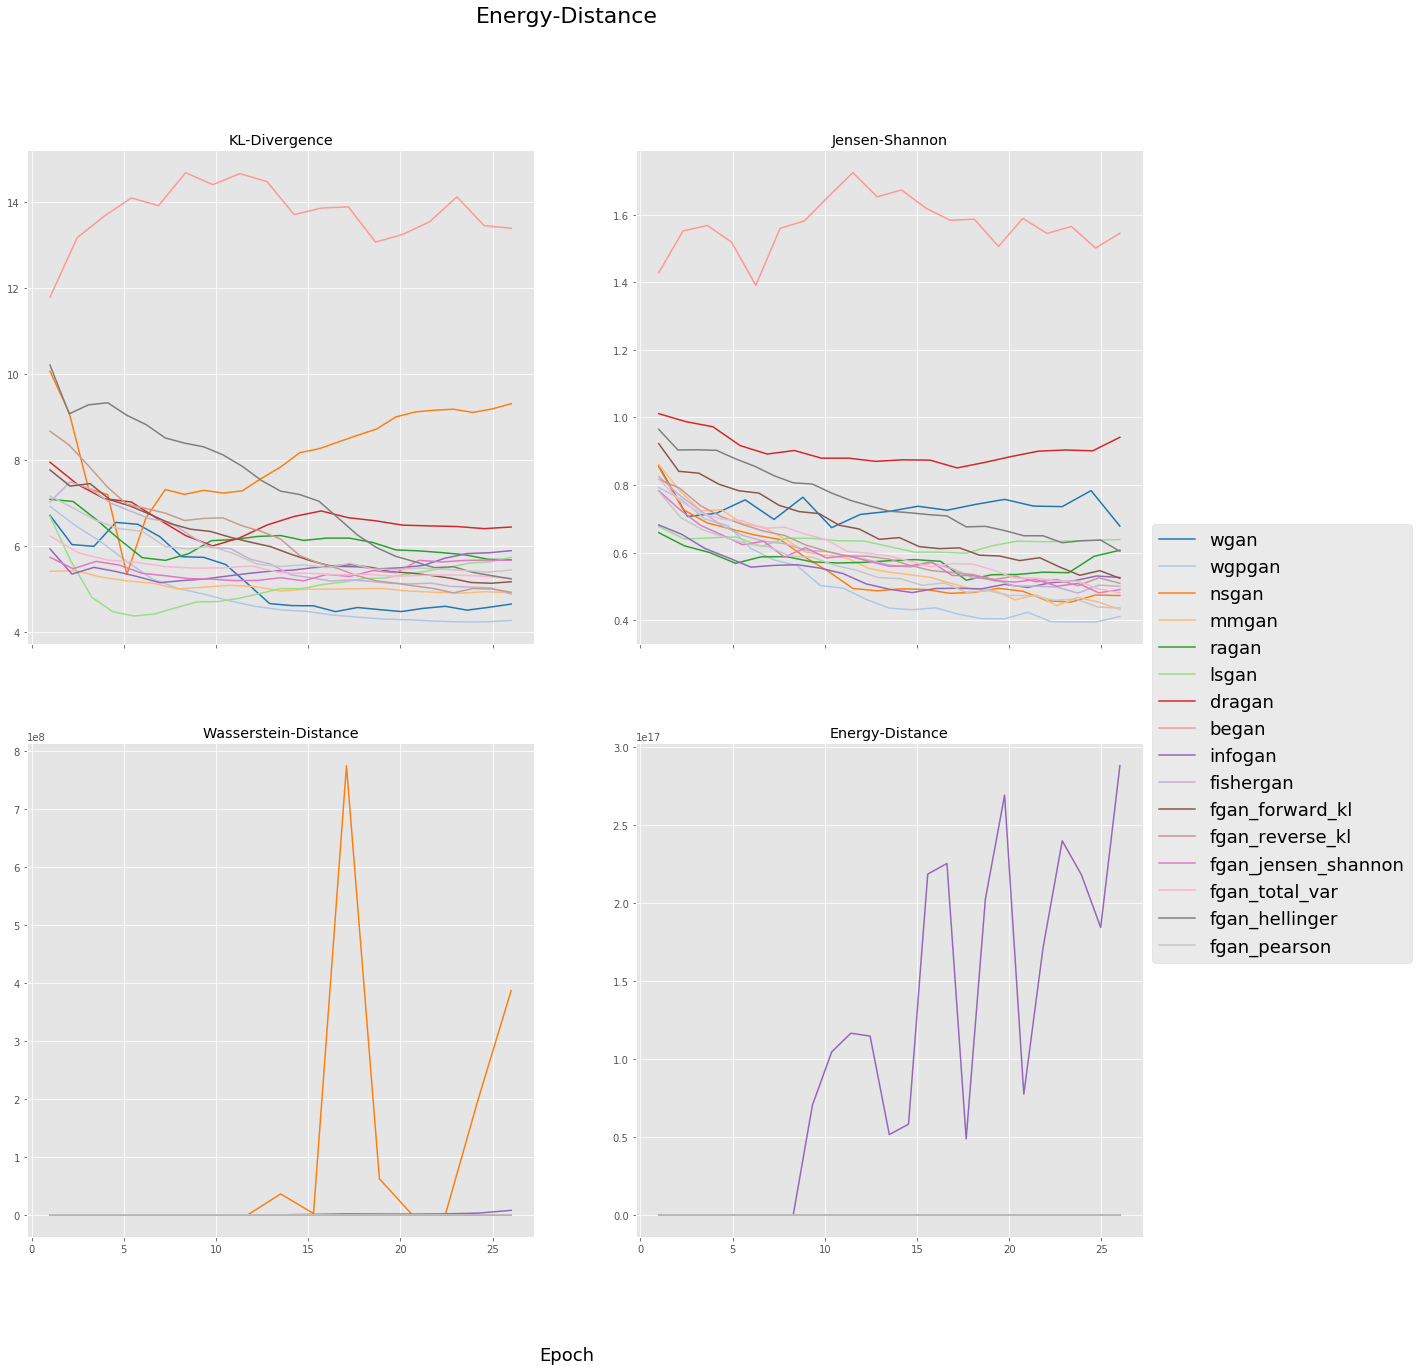

In [30]:
print(""" Plot mean performance across epochs for MNIST """)
graph_mnist(optimal, omit_outliers=True, thresh=2.5)

In [72]:
print(""" Print confidence intervals for minimum across all runs\n """)
rankings_dict = nested_pickle_dict()
param_dict = nested_pickle_dict()

for metric in distance_metrics:

    for model_name in model_names:

        minimums = np.nanmin(np.array(optimal[model_name]['mnist'][metric]['values']), axis=1)
        mu, h, low, high = mean_confidence_interval(minimums)
        param_dict[metric][model_name]['mnist'] = '%.3f ± %.3f' % (np.round(mu, 3), np.round(h, 3))

data = [[key, param_dict['KL-Divergence'][key]['mnist'], param_dict['Jensen-Shannon'][key]['mnist'],
              param_dict['Wasserstein-Distance'][key]['mnist'], param_dict['Energy-Distance'][key]['mnist']]
         for key in model_names]
print(tabulate(data, headers=['Model', 'KL-Divergence', 'Jensen-Shannon', 'Wasserstein-Distance', 'Energy-Distance']), '\n')

rankings = np.argsort([[eval(i[:4]) if i[:4] != 'nan ' else 1e10 for i in j[1:]] for j in data], axis=0)

 Print confidence intervals for minimum across all runs
 
Model                KL-Divergence    Jensen-Shannon    Wasserstein-Distance    Energy-Distance
-------------------  ---------------  ----------------  ----------------------  ------------------
wgan                 4.125 ± 0.099    0.426 ± 0.011     316780.126 ± 4436.087   4013.579 ± 84.598
wgpgan               3.748 ± 0.083    0.361 ± 0.006     314598.559 ± 4030.871   3859.946 ± 93.794
nsgan                4.357 ± 0.105    0.395 ± 0.005     296550.915 ± 8852.130   3775.334 ± 123.176
mmgan                4.476 ± 0.098    0.405 ± 0.011     314523.160 ± 4985.008   3698.323 ± 151.662
ragan                4.332 ± 0.188    0.401 ± 0.007     296241.814 ± 9854.404   3866.872 ± 158.026
lsgan                4.050 ± 0.092    0.500 ± 0.012     315946.582 ± 4797.898   4145.958 ± 76.656
dragan               4.911 ± 0.117    0.694 ± 0.022     316112.630 ± 3932.823   4212.852 ± 68.878
began                5.608 ± 0.124    0.563 ± 0.025     25

In [69]:
print(""" Get relative ranking performance based on mean minimum performance\n """)
print('0 is the best performance.\n')

print(tabulate([[key, rankings[idx, 0], rankings[idx, 1], rankings[idx, 2], rankings[idx, 3]]
                 for idx, key in enumerate(model_names)], 
               headers=['Model', 'KL-Divergence', 'Jensen-Shannon', 'Wasserstein-Distance', 'Energy-Distance']))

 Get relative ranking performance based on mean minimum performance
 
0 is the best performance.

Model                  KL-Divergence    Jensen-Shannon    Wasserstein-Distance    Energy-Distance
-------------------  ---------------  ----------------  ----------------------  -----------------
wgan                               1                 1                       7                  3
wgpgan                             5                 2                       8                  2
nsgan                              0                 3                       4                  8
mmgan                             12                 4                       2                  1
ragan                              4                15                      13                  4
lsgan                              2                 8                      12                 15
dragan                             8                 0                      11                  0
began               

 Plot mean minimum performance with error bars as a function of number samples 


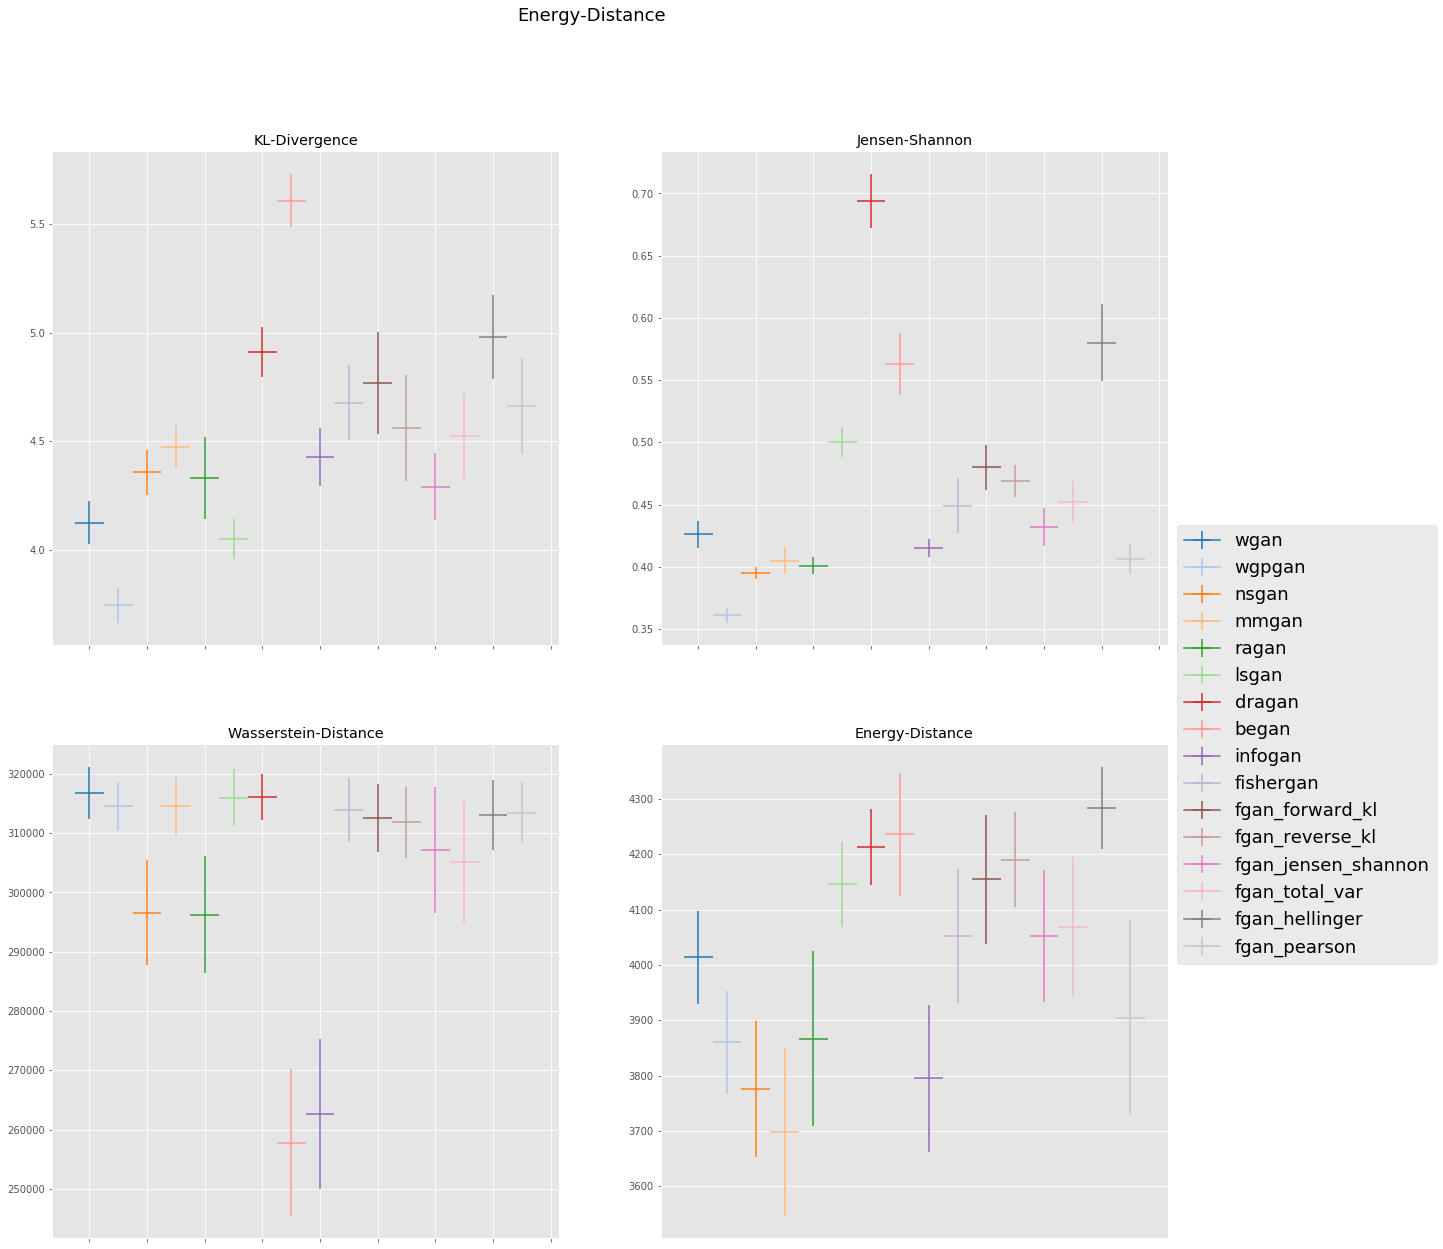

In [104]:
print(""" Plot mean minimum performance with error bars as a function of number samples """)

plt_idx = [(0, 0), (0, 1), (1, 0), (1, 1)]
fig, axes = plt.subplots(2, 2, sharex=True, sharey=False, figsize=(20,20))

for d_idx, metric in enumerate(distance_metrics):

    for idx, model_name in enumerate(model_names):

        x, y, yerr = [], [], []
        for key, val in param_dict[metric][model_name].items():
            if key == 'error':
                continue

            mu, err = val.split('±')
            x.append(idx), y.append(float(mu)), yerr.append(float(err))

        axes[plt_idx[d_idx][0], plt_idx[d_idx][1]].errorbar(x, y, xerr=0.5, yerr=yerr,
                                                              barsabove=False, label=model_name,
                                                              c=palette[idx], ecolor=palette[idx])
    axes[plt_idx[d_idx][0], plt_idx[d_idx][1]].set_title("{0}".format(metric))
    axes[plt_idx[d_idx][0], plt_idx[d_idx][1]].xaxis.set_ticklabels([])

fig.suptitle("{0}".format(metric), fontsize=18)
plt.legend(loc='center left', bbox_to_anchor=(1, 1), fontsize=18)
plt.gca().axes.get_xaxis().set_visible(False)
plt.show()

In [114]:
print(""" Get number of different hyperparameters for each minimum run\n """)

for metric in distance_metrics:
    
    param_dict = nested_pickle_dict()
                            
    for model_name in model_names:
        if 'mnist' not in param_dict[model_name]:
            param_dict[model_name]['mnist'] = []
        param_dict[model_name]['mnist'].append(len(set([tuple(t) for t in optimal[model_name]['mnist'][metric]['parameters']])))

print(tabulate([[key, param_dict[key]['mnist'][0]]
                 for idx, key in enumerate(model_names)], 
               headers=['Model', 'Num. Params']))

 Get number of different hyperparameters for each minimum run
 
Model                  Num. Params
-------------------  -------------
wgan                             9
wgpgan                          11
nsgan                            9
mmgan                           10
ragan                           15
lsgan                           12
dragan                          13
began                           11
infogan                         13
fishergan                       14
fgan_forward_kl                 15
fgan_reverse_kl                 14
fgan_jensen_shannon             13
fgan_total_var                  15
fgan_hellinger                  14
fgan_pearson                    11
